In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import plotly.graph_objects as go

Total samples: 890, Training samples: 712, Validation samples: 178


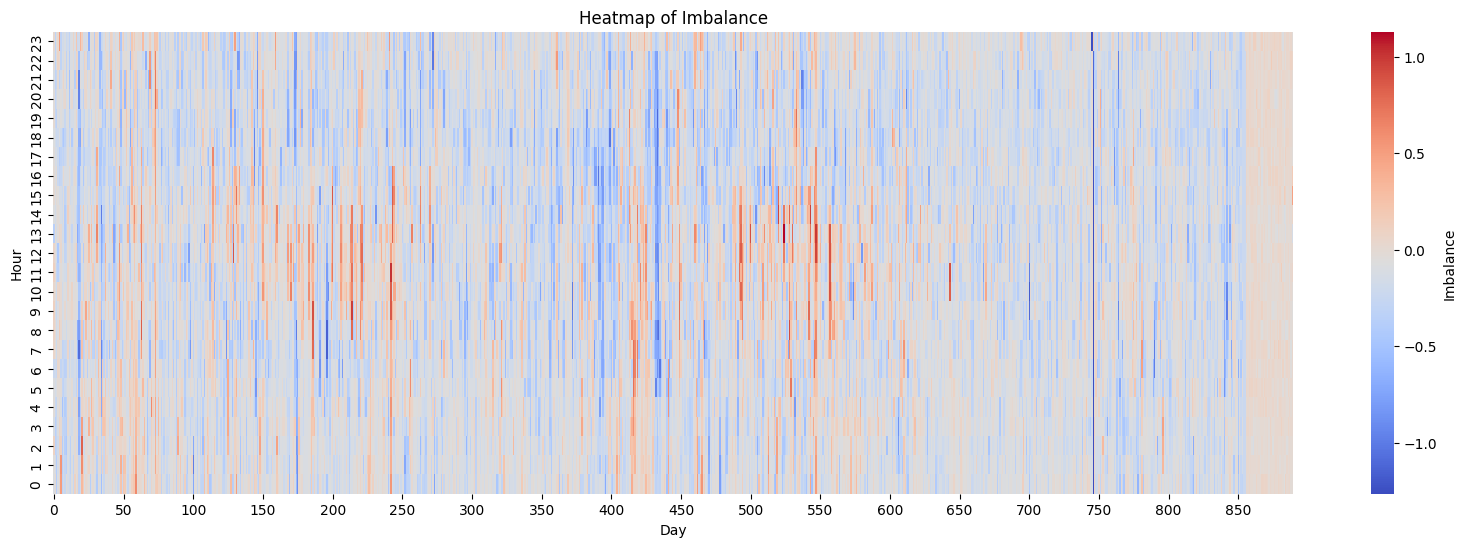

In [3]:
X = np.load("../data/X2.npy")

target = X[:, 0, :]
condition = X[:, 1:, :]

cond_tensor = torch.tensor(condition, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)

dataset = TensorDataset(cond_tensor, target_tensor)

cond_dim = 9 * 24
target_dim = 24
latent_dim = 32

n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

print(f"Total samples: {n_total}, Training samples: {n_train}, Validation samples: {n_val}")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)


plt.figure(figsize=(20, 6))
ax = sns.heatmap(target.T, cmap='coolwarm', cbar_kws={'label': 'Imbalance'}, xticklabels=50)
ax.set_xlabel("Day")
ax.set_ylabel("Hour")
plt.title("Heatmap of Imbalance")
plt.gca().invert_yaxis()
plt.show()


In [4]:
class MLPBlock(nn.Module):
    def __init__(self, input_dim, dropout_prob):
        super(MLPBlock, self).__init__()
        inner_dim = 4 * input_dim 
        self.layer_norm = nn.LayerNorm(input_dim)
        self.fc1 = nn.Linear(input_dim, inner_dim)
        self.fc2 = nn.Linear(inner_dim, input_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        residual = x
        x = self.layer_norm(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x + residual

In [5]:
class Encoder(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim, mlp_blocks, hidden_dim, dropout_prob):
        super(Encoder, self).__init__()
        input_dim = cond_dim + target_dim
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.mlp = nn.Sequential(*[MLPBlock(hidden_dim, dropout_prob) for _ in range(mlp_blocks)])
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, cond, target):
        batch_size = cond.shape[0]
        cond_flat = cond.view(batch_size, -1)
        target_flat = target.view(batch_size, -1)

        x = torch.cat([cond_flat, target_flat], dim=1)
        x = self.input_layer(x)
        x = self.mlp(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

In [6]:
class Decoder(nn.Module):
    def __init__(self, cond_dim, latent_dim, target_dim, mlp_blocks, hidden_dim, dropout_prob):
        super(Decoder, self).__init__()
        #nput_dim = cond_dim + latent_dim
        self.fc_c = nn.Linear(cond_dim, hidden_dim)
        self.fc_z = nn.Linear(latent_dim, hidden_dim)
        self.relu = nn.ReLU()
        # self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.mlp = nn.Sequential(*[MLPBlock(hidden_dim, dropout_prob) for _ in range(mlp_blocks)])
        # self.output_layer = nn.Linear(hidden_dim, target_dim)
        self.out_mu     = nn.Linear(hidden_dim, target_dim)
        self.out_logvar = nn.Linear(hidden_dim, target_dim)
    
    def forward(self, cond, z):
        batch_size = cond.shape[0]
        cond_flat = cond.view(batch_size, -1)
        h_c = self.fc_c(cond_flat)
        h_z = self.fc_z(z)
        h = self.relu(h_c + h_z)

        h = self.mlp(h)
        # x = torch.cat([cond_flat, z], dim=1)
        # x = self.input_layer(x)
        # x = self.mlp(x)
        # out = self.output_layer(h)
        # return out
        mu_hat    = self.out_mu(h)
        logvar_hat = self.out_logvar(h).clamp(-10, 10)
        return mu_hat, logvar_hat

In [7]:
# 3, 192, 0.15
class CVAE(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim, mlp_blocks, hidden_dim, dropout_prob):
        super(CVAE, self).__init__()
        self.encoder = Encoder(cond_dim, target_dim, latent_dim, mlp_blocks, hidden_dim, dropout_prob)
        self.decoder = Decoder(cond_dim, latent_dim, target_dim, mlp_blocks, hidden_dim, dropout_prob)
    
    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, cond, target):
        mu, logvar = self.encoder(cond, target)   
        z = self.reparameterize(mu, logvar)
        mu_hat, logvar_hat = self.decoder(cond, z)
        
        return mu_hat, logvar_hat, mu, logvar

In [47]:
# def loss_function(recon_target, target, mu, logvar, kl_weight=1.0, min_kl=0.03, return_components=False):
    # recon_loss = F.mse_loss(recon_target, target, reduction='mean')
    # torch.mean
    # raw_kl_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    
    # Enforce minimum KL divergence
    # kl_loss_dim = torch.clamp(raw_kl_loss, min=min_kl)

    # kl_loss = kl_loss_dim.mean()
    # total_loss = recon_loss + kl_weight * kl_loss
    
    # if return_components:
        # return total_loss, recon_loss, kl_loss
    # return total_loss

In [8]:
def loss_function(mu_hat, logvar_hat, target, mu, logvar, kl_weight=1.0, min_kl=0.03, return_components=False):
    recon_nll = 0.5 * (logvar_hat + (target - mu_hat).pow(2).div(logvar_hat.exp())).mean()
    kl_per_dim = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    kl_per_dim = torch.clamp(kl_per_dim, min=min_kl)
    kl_loss = kl_per_dim.mean()

    total_loss = recon_nll + kl_weight * kl_loss

    if return_components:
        return total_loss, recon_nll, kl_loss
    return total_loss

In [9]:
final_beta = 0.1

def calculate_kl_weight(epoch, warmup_epochs, final_beta=final_beta):
    if epoch < warmup_epochs:
        return (epoch / warmup_epochs) * final_beta
    return final_beta

In [9]:
def pinball_loss(y_true, y_pred, quantile):
    error = y_true - y_pred
    loss_tensor = torch.where(error >= 0, quantile * error, (quantile - 1) * error)
    loss = torch.mean(loss_tensor)
    return loss

In [10]:
def crps_loss(y_true, samples):
    num_samples = samples.shape[0]
    y_true_expanded = y_true.unsqueeze(0).expand(num_samples, *y_true.shape)
    
    # First term: average absolute difference between each sample and the true value.
    term1 = torch.abs(samples - y_true_expanded).mean(dim=0)
    
    # Second term: average pairwise absolute differences among samples.
    # Compute pairwise differences along the sample axis.
    diff = torch.abs(samples.unsqueeze(0) - samples.unsqueeze(1))
    term2 = diff.mean(dim=(0, 1))  # shape: [batch, target_dim]
    
    # CRPS per instance and target dimension.
    crps = term1 - 0.5 * term2
    # Return the average CRPS over the batch and target dimensions.
    return crps.mean()

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(cond_dim, target_dim, latent_dim, mlp_blocks=2, hidden_dim=96, dropout_prob=0.3).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

In [27]:
num_epochs = 500
warmup_epochs = int(0.10 * num_epochs)
mask_ratio = 0.2

# Lists to track metrics
train_losses = []
val_losses = []
kl_weights = []
recon_losses = []
kl_losses = []
weighted_kl_losses = []
masked_rmses = []

for epoch in range(num_epochs):
    kl_weight = calculate_kl_weight(epoch=epoch, warmup_epochs=warmup_epochs)
    kl_weights.append(kl_weight)
    
    model.train()
    train_loss = 0.0
    epoch_recon_loss = 0.0
    epoch_kl_loss = 0.0
    epoch_weighted_kl_loss = 0.0
    epoch_masked_se = 0.0
    epoch_masked_count = 0
    
    for batch_cond, batch_target in train_loader:
        batch_cond = batch_cond.to(device)
        batch_target = batch_target.to(device)
        batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)

        #mask = torch.bernoulli(torch.full_like(batch_target, 1 - mask_ratio)).to(device)
        #batch_target_masked = batch_target * mask
        
        optimizer.zero_grad()
        mu_hat, logvar_hat, mu, logvar = model(batch_cond_flat, batch_target)
        loss, recon_nll, kl_term = loss_function(
            mu_hat, logvar_hat, batch_target, mu, logvar, kl_weight, return_components=True
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item() * batch_cond.size(0)
        epoch_recon_loss += recon_nll.item() * batch_cond.size(0)
        epoch_kl_loss += kl_term.item() * batch_cond.size(0)
        epoch_weighted_kl_loss += (kl_weight * kl_term.item()) * batch_cond.size(0)

        # inv_mask = 1.0 - mask
        # se = ((recon_target - batch_target)**2 * inv_mask).sum().item()
        # count = inv_mask.sum().item()
        # epoch_masked_se += se
        # epoch_masked_count += count
    
    # Average losses over the dataset
    avg_train_loss = train_loss / len(train_dataset)
    avg_recon_loss = epoch_recon_loss / len(train_dataset)
    avg_kl_loss = epoch_kl_loss / len(train_dataset)
    avg_weighted_kl_loss = epoch_weighted_kl_loss / len(train_dataset)

    # if epoch_masked_count > 0:
    #     masked_rmse = (epoch_masked_se / epoch_masked_count) ** 0.5
    # else:
    #     masked_rmse = 0.0
    # masked_rmses.append(masked_rmse)
    
    train_losses.append(avg_train_loss)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(avg_kl_loss)
    weighted_kl_losses.append(avg_weighted_kl_loss)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    val_recon_loss = 0.0
    val_kl_loss = 0.0
    val_weighted_kl_loss = 0.0
    
    with torch.no_grad():
        for batch_cond, batch_target in val_loader:
            batch_cond = batch_cond.to(device)
            batch_target = batch_target.to(device)
            batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
            mu_hat, logvar_hat, mu, logvar = model(batch_cond_flat, batch_target)
            loss, recon_nll_val, kl_term_val = loss_function(
                mu_hat, logvar_hat, batch_target, mu, logvar, kl_weight, return_components=True
            )
            val_loss += loss.item() * batch_cond.size(0)
            val_recon_loss += recon_nll_val.item() * batch_cond.size(0)
            val_kl_loss += kl_term_val.item() * batch_cond.size(0)
            val_weighted_kl_loss += (kl_weight * kl_term_val.item()) * batch_cond.size(0)
    
    avg_val_loss = val_loss / len(val_dataset)
    avg_val_recon_loss = val_recon_loss / len(val_dataset)
    avg_val_kl_loss = val_kl_loss / len(val_dataset)
    avg_val_weighted_kl_loss = val_weighted_kl_loss / len(val_dataset)
    
    val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, KL Weight: {kl_weight:.4f}")
        print(f"Train Loss: {avg_train_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}, Weighted KL: {avg_weighted_kl_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Recon Loss: {avg_val_recon_loss:.4f}, Val KL Loss: {avg_val_kl_loss:.4f}, Val Weighted KL: {avg_val_weighted_kl_loss:.4f}")
        # print(f"Masked‐region RMSE: {masked_rmse:.4f}")

Epoch 1/500, KL Weight: 0.0000
Train Loss: 0.6873, Recon Loss: 0.6873, KL Loss: 1.4417, Weighted KL: 0.0000
Val Loss: 0.3503, Val Recon Loss: 0.3503, Val KL Loss: 1.2721, Val Weighted KL: 0.0000
Epoch 100/500, KL Weight: 0.1000
Train Loss: -1.1740, Recon Loss: -1.2443, KL Loss: 0.7032, Weighted KL: 0.0703
Val Loss: -1.1031, Val Recon Loss: -1.1756, Val KL Loss: 0.7254, Val Weighted KL: 0.0725
Epoch 200/500, KL Weight: 0.1000
Train Loss: -1.4031, Recon Loss: -1.4923, KL Loss: 0.8917, Weighted KL: 0.0892
Val Loss: -1.2815, Val Recon Loss: -1.3719, Val KL Loss: 0.9044, Val Weighted KL: 0.0904
Epoch 300/500, KL Weight: 0.1000
Train Loss: -1.5593, Recon Loss: -1.6624, KL Loss: 1.0304, Weighted KL: 0.1030
Val Loss: -1.4038, Val Recon Loss: -1.5060, Val KL Loss: 1.0223, Val Weighted KL: 0.1022
Epoch 400/500, KL Weight: 0.1000
Train Loss: -1.6739, Recon Loss: -1.7871, KL Loss: 1.1317, Weighted KL: 0.1132
Val Loss: -1.4250, Val Recon Loss: -1.5388, Val KL Loss: 1.1382, Val Weighted KL: 0.1138
E

In [15]:
import torch

def mask_and_print(target: torch.Tensor, mask_ratio: float = 0.2):
    """
    Zero‐out a random fraction of the entries in `target`, then print
    the mask and the masked target.

    Args:
        target      (Tensor):    your target vector / tensor
        mask_ratio  (float):     fraction of entries to mask (0–1)
    Returns:
        masked_target, mask
    """
    # 1) build a bernoulli mask: 1=keep, 0=mask
    mask = torch.bernoulli(torch.full_like(target, 1.0 - mask_ratio))
    # 2) apply it
    masked_target = target * mask

    # 3) print for inspection
    print("Mask (1=keep, 0=masked):\n", mask)
    print("\nMasked target:\n", masked_target)

    return masked_target, mask

# ── Example usage ──
# Grab one batch from your loader, pick the first example’s target:
batch_cond, batch_target = next(iter(train_loader))
single_target = batch_target[0]        # shape: (24,) or whatever your target_dim is
mask_and_print(single_target, mask_ratio=0.2)


Mask (1=keep, 0=masked):
 tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        1., 1., 1., 0., 1., 1.])

Masked target:
 tensor([-0.1002, -0.0000, -0.0000, -0.1078, -0.0188,  0.0343,  0.0294, -0.0000,
         0.2650,  0.0000, -0.0292, -0.3426, -0.3791, -0.2482, -0.0000, -0.0000,
        -0.2910, -0.0000, -0.2448, -0.1477, -0.3860, -0.0000, -0.6572, -0.6770])


(tensor([-0.1002, -0.0000, -0.0000, -0.1078, -0.0188,  0.0343,  0.0294, -0.0000,
          0.2650,  0.0000, -0.0292, -0.3426, -0.3791, -0.2482, -0.0000, -0.0000,
         -0.2910, -0.0000, -0.2448, -0.1477, -0.3860, -0.0000, -0.6572, -0.6770]),
 tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
         1., 1., 1., 0., 1., 1.]))

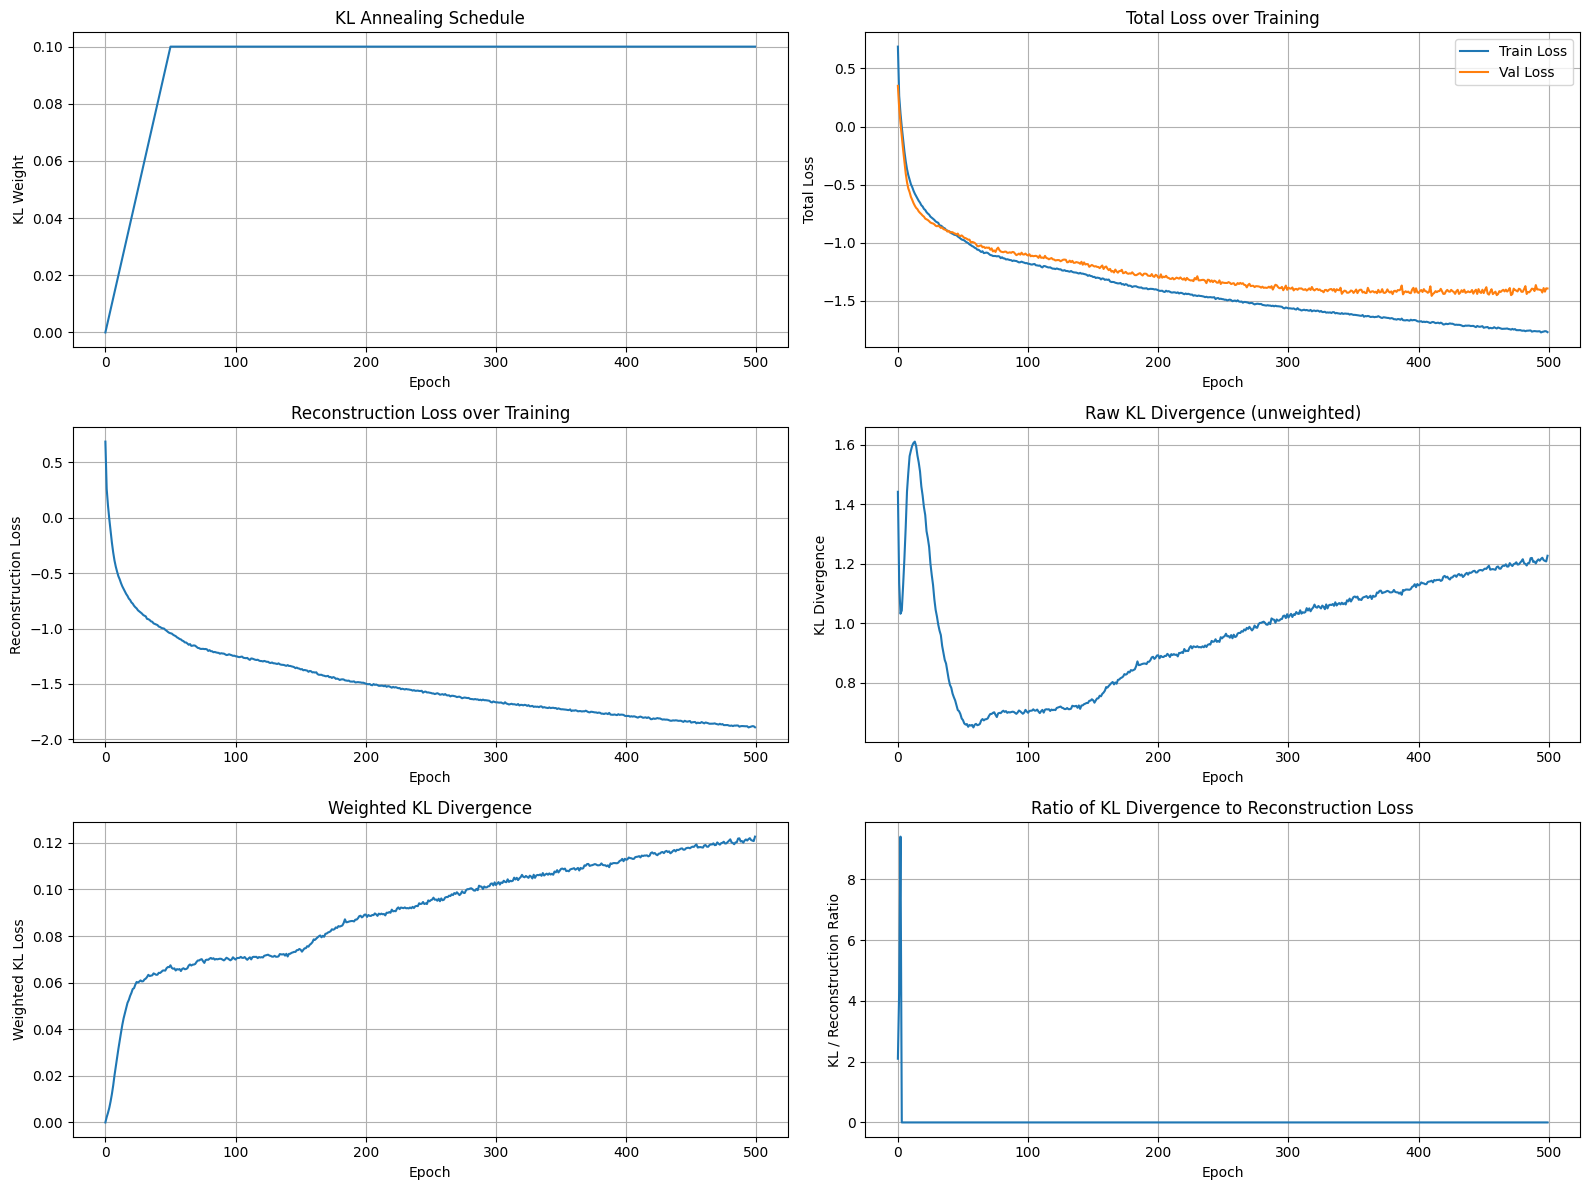

In [28]:
plt.figure(figsize=(16, 12))

# Plot 1: KL weight over time
plt.subplot(3, 2, 1)
plt.plot(kl_weights)
plt.xlabel('Epoch')
plt.ylabel('KL Weight')
plt.title('KL Annealing Schedule')
plt.grid(True)

# Plot 2: Total losses over time
plt.subplot(3, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Loss over Training')
plt.legend()
plt.grid(True)

# Plot 3: Reconstruction loss over time
plt.subplot(3, 2, 3)
plt.plot(recon_losses)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss over Training')
plt.grid(True)

# Plot 4: Raw KL divergence over time
plt.subplot(3, 2, 4)
plt.plot(kl_losses)
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.title('Raw KL Divergence (unweighted)')
plt.grid(True)

# Plot 5: Weighted KL divergence over time
plt.subplot(3, 2, 5)
plt.plot(weighted_kl_losses)
plt.xlabel('Epoch')
plt.ylabel('Weighted KL Loss')
plt.title('Weighted KL Divergence')
plt.grid(True)

# Plot 6: Ratio of KL to reconstruction loss
plt.subplot(3, 2, 6)
ratio = [kl/recon if recon > 0 else 0 for kl, recon in zip(kl_losses, recon_losses)]
plt.plot(ratio)
plt.xlabel('Epoch')
plt.ylabel('KL / Reconstruction Ratio')
plt.title('Ratio of KL Divergence to Reconstruction Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
def evaluate_pinball(model, data_loader, device, quantiles=[0.1, 0.5, 0.9], num_samples=100):
    model.eval()
    results = {q: 0.0 for q in quantiles}
    
    with torch.no_grad():
        for batch_cond, batch_target in data_loader:
            batch_cond = batch_cond.to(device)
            batch_target = batch_target.to(device)
            batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
            
            # Generate samples from prior
            samples = []
            batch_size = batch_cond.size(0)
            
            for _ in range(num_samples):
                # Sample from prior directly
                z = torch.randn(batch_size, latent_dim, device=device)
                pred = model.decoder(batch_cond_flat, z)
                samples.append(pred.unsqueeze(0))
                
            all_samples = torch.cat(samples, dim=0)
            
            # Evaluate each quantile
            for q in quantiles:
                q_pred = torch.quantile(all_samples, q, dim=0)
                loss = pinball_loss(batch_target, q_pred, q)
                results[q] += loss.item() * batch_size
    
    # Normalize
    for q in quantiles:
        results[q] /= len(data_loader.dataset)
        
    return results

In [14]:
def evaluate_crps(model, data_loader, device, num_samples=100):
    model.eval()
    total_crps = 0.0
    
    with torch.no_grad():
        for batch_cond, batch_target in data_loader:
            batch_cond = batch_cond.to(device)
            batch_target = batch_target.to(device)
            batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
            
            # Generate samples from prior
            samples = []
            batch_size = batch_cond.size(0)
            
            for _ in range(num_samples):
                # Sample from prior N(0,1) directly 
                z = torch.randn(batch_size, latent_dim, device=device)
                # Generate prediction from sampled latent
                pred = model.decoder(batch_cond_flat, z)
                samples.append(pred.unsqueeze(0))
                
            # Concatenate samples: shape becomes [num_samples, batch, target_dim]
            samples = torch.cat(samples, dim=0)
            
            # Compute CRPS
            batch_crps = crps_loss(batch_target, samples)
            total_crps += batch_crps.item() * batch_size
    
    return total_crps / len(data_loader.dataset)

In [15]:
print(f"CRPS: {evaluate_crps(model, train_loader, device)} - Pinball: {evaluate_pinball(model, train_loader, device)}")

CRPS: 0.011849967051255569 - Pinball: {0.1: 0.004808128936990594, 0.5: 0.007167947091413348, 0.9: 0.004930887920677327}


In [19]:
model.eval()
with torch.no_grad():
    sample_cond, sample_target = next(iter(val_loader))
    sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
    sample_target = sample_target.to(device)
    
    mu, logvar = model.encoder(sample_cond_flat, sample_target)
    recon_target = model.decoder(sample_cond_flat, mu)
    
    print("\nValidation Samples and Predictions (First 5):")
    for i in range(5):
        print(f"\nSample {i+1} True Imbalance:")
        print(sample_target[i])
        print(f"Sample {i+1} Predicted Imbalance:")
        print(recon_target[i])



Validation Samples and Predictions (First 5):

Sample 1 True Imbalance:
tensor([-0.1042, -0.0953, -0.3616, -0.3418, -0.3595, -0.0810, -0.3045, -0.3720,
        -0.3419, -0.3256, -0.2353, -0.1996, -0.0820, -0.0442, -0.2117, -0.3778,
        -0.2430, -0.4182, -0.4197, -0.2384, -0.1726, -0.2370, -0.1586, -0.0779])
Sample 1 Predicted Imbalance:
tensor([ 0.0484, -0.1229, -0.1224, -0.0809, -0.0478, -0.0782, -0.1047, -0.2354,
         0.1109, -0.0192, -0.0436, -0.2371, -0.3083, -0.2690,  0.0960, -0.0753,
        -0.0872, -0.0300,  0.0747, -0.1978, -0.0386,  0.0463,  0.0272, -0.1090])

Sample 2 True Imbalance:
tensor([-0.1611, -0.2740, -0.2988, -0.3473, -0.2420, -0.1263, -0.0016,  0.0251,
        -0.0937,  0.0835, -0.1000, -0.3389, -0.3327, -0.0796,  0.0139, -0.0682,
        -0.4335, -0.0240,  0.4773,  0.3180, -0.1208, -0.0485,  0.0910,  0.0767])
Sample 2 Predicted Imbalance:
tensor([ 0.0115, -0.0174, -0.0697, -0.0205, -0.0555, -0.0936, -0.0693,  0.0841,
         0.1397,  0.1125,  0.1122,  0.

In [20]:
num_samples = 16
samples = []
sample_cond, sample_target = next(iter(val_loader))
sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
sample_target = sample_target.to(device)

model.eval()
with torch.no_grad():
    for i in range(num_samples):
        mu, logvar = model.encoder(sample_cond_flat, sample_target)
        z = model.reparameterize(mu, logvar)
        recon_target = model.decoder(sample_cond_flat, z)
        samples.append(recon_target.cpu().numpy())


In [76]:
batch_index = 0
traces = []
traces.append({"y": sample_target.cpu().numpy()[batch_index], "name": "Target"})
for i, sample in enumerate(samples):
    traces.append({"y": sample[batch_index], "name": f"Sample {i}"})

go.Figure(data=traces)

In [29]:
def get_doy_and_dow_from_validation(val_dataset, val_index):
    sample_cond, sample_target = val_dataset[val_index]
    target_numpy = sample_target.numpy()

    day_sin = sample_cond[5, 0].item()
    day_cos = sample_cond[6, 0].item()
    week_sin = sample_cond[7, 0].item()
    week_cos = sample_cond[8, 0].item()

    day_rad = np.arctan2(day_sin, day_cos)
    day_angle = day_rad if day_rad >= 0 else day_rad + (2 * np.pi)
    day_of_year_float = (day_angle / (2 * np.pi)) * 365.25
    day_of_year = int(np.clip(round(day_of_year_float), 1, 365))

    week_rad = np.arctan2(week_sin, week_cos)
    week_angle = week_rad if week_rad >= 0 else week_rad + (2 * np.pi)
    day_of_week_float = (week_angle / (2 * np.pi)) * 7.0
    day_of_week = int(round(day_of_week_float) % 7)

    return day_of_year, day_of_week, target_numpy

In [30]:
def find_week_earlier_target_with_dow(current_doy, current_dow, X):
    target_dow = current_dow % 7
    target_doy = (current_doy - 1 - 7) % 365 + 1

    all_week_sin, all_week_cos = X[:, 7, 0], X[:, 8, 0]
    all_week_rad = np.arctan2(all_week_sin, all_week_cos)
    all_week_angle = np.where(all_week_rad >= 0, all_week_rad, all_week_rad + (2 * np.pi))
    all_calculated_dow = np.round((all_week_angle / (2 * np.pi)) * 7.0).astype(int) % 7

    dow_match_indices = np.where(all_calculated_dow == target_dow)[0]
    if len(dow_match_indices) == 0: return None

    subset_day_sin = X[dow_match_indices, 5, 0]
    subset_day_cos = X[dow_match_indices, 6, 0]
    subset_day_rad = np.arctan2(subset_day_sin, subset_day_cos)
    subset_day_angle = np.where(subset_day_rad >= 0, subset_day_rad, subset_day_rad + (2 * np.pi))
    subset_doy_float = (subset_day_angle / (2 * np.pi)) * 365.25
    subset_calculated_doy = np.clip(np.round(subset_doy_float), 1, 365).astype(int)

    diff = np.abs(subset_calculated_doy - target_doy)
    min_diff = np.minimum(diff, 365 - diff)
    best_subset_idx = np.argmin(min_diff)
    original_idx = dow_match_indices[best_subset_idx]

    return X[original_idx, 0, :]

In [31]:
def evaluate_imbalance_improvement(target_data, prediction_data, label="Prediction"):
    pred_abs = np.abs(prediction_data)
    actual_abs = np.abs(target_data)

    improvements = np.sum(pred_abs < actual_abs)
    total_points = target_data.size
    abs_diff = np.mean(np.abs(pred_abs - actual_abs))

    print(f"  Metrics for {label}:")
    imp_perc = improvements / total_points * 100 if total_points > 0 else 0
    print(f"    Improvement Percentage: {imp_perc:.2f}% ")
    print(f"    Avg Absolute Diff:    {abs_diff:.4f}")

    return True

In [32]:
doy, dow, target_data = get_doy_and_dow_from_validation(val_dataset, 0)
print(f"\nCalculated - DoY: {doy}, DoW: {dow}")

week_earlier_data = find_week_earlier_target_with_dow(doy, dow, X)
print(week_earlier_data)


Calculated - DoY: 350, DoW: 0
[ 0.14460001  0.1775      0.47829999  0.1092      0.0017     -0.188
 -0.15710001 -0.1792     -0.0872     -0.0542     -0.1171      0.1653
  0.21210001  0.55829999  0.653       0.0615      0.         -0.13289999
 -0.0577     -0.1177     -0.0765     -0.0401     -0.1368     -0.0201    ]


In [33]:
def plot_val_sample_with_week_earlier(model, X, val_dataset, val_index, num_samples=16):
    doy, dow, target_data = get_doy_and_dow_from_validation(val_dataset, val_index)
    if target_data is None: return None

    week_earlier_data = find_week_earlier_target_with_dow(doy, dow, X)
    if week_earlier_data is not None: print(f"Week Earlier Data Found:\n{week_earlier_data[:5]}...\n{'-'*20}")
    else: print(f"Week Earlier Data Not Found.\n{'-'*20}")

    sample_cond, sample_target = val_dataset[val_index]
    cond_dev = sample_cond.unsqueeze(0).to(device)
    target_dev = sample_target.unsqueeze(0).to(device)
    cond_flat = cond_dev.view(1, -1)

    model.eval()
    samples_list = []
    with torch.no_grad():
        for _ in range(num_samples):
            mu, logvar = model.encoder(cond_flat, target_dev)
            z = model.reparameterize(mu, logvar)
            recon = model.decoder(cond_flat, z)
            samples_list.append(recon.cpu().numpy().flatten())

    traces = [go.Scatter(y=target_data, name="Target", line=dict(color='black', width=2))]
    if week_earlier_data is not None:
        traces.append(go.Scatter(y=week_earlier_data, name="Week Earlier", line=dict(color='red', width=2)))
    for i, sample in enumerate(samples_list):
         traces.append(go.Scatter(y=sample, name=f"Recon {i+1}", showlegend=True, line=dict(color='blue', width=1), opacity=0.8))

    fig = go.Figure(data=traces)
    fig.update_layout(title=f"Val Idx {val_index}", xaxis_title="Hour", yaxis_title="Value")
    return fig

In [74]:
fig = plot_val_sample_with_week_earlier(model, X, val_dataset, 3)
if fig: fig.show()

Week Earlier Data Found:
[-0.0168      0.0939      0.0631      0.20360001 -0.24060001]...
--------------------


AttributeError: 'tuple' object has no attribute 'cpu'

In [34]:
def plot_val_sample_generation_with_week_earlier(model, X, val_dataset, latent_dim, val_index, num_samples=16):
    doy, dow, target_data = get_doy_and_dow_from_validation(val_dataset, val_index)
    if target_data is None: return None

    week_earlier_data = find_week_earlier_target_with_dow(doy, dow, X)
    if week_earlier_data is not None: print(f"Week Earlier Data Found:\n{week_earlier_data[:5]}...\n{'-'*20}")
    else: print(f"Week Earlier Data Not Found.\n{'-'*20}")

    scalar_mean_target = np.mean(X[:, 0, :])
    mean_line_data = np.full(target_data.shape[0], scalar_mean_target)

    sample_cond, _ = val_dataset[val_index]
    cond_flat = sample_cond.unsqueeze(0).to(device).view(1, -1)

    model.eval()
    samples_list = []
    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, latent_dim).to(device)
            mu_hat, logvar_hat = model.decoder(cond_flat, z)
            eps = torch.randn_like(logvar_hat)
            recon = mu_hat + eps * torch.exp(0.5 * logvar_hat)
            samples_list.append(recon.cpu().numpy().flatten())

    traces = [
        go.Scatter(y=target_data, name="Target", line=dict(color='black', width=2)),
        # Plot the repeated scalar mean as a horizontal line
        go.Scatter(y=mean_line_data, name="Overall Mean", line=dict(color='grey', width=2, dash='dash'))
    ]
    if week_earlier_data is not None:
        traces.append(go.Scatter(y=week_earlier_data, name="Week Earlier", line=dict(color='red', width=2)))
    for i, sample in enumerate(samples_list):
         traces.append(go.Scatter(y=sample, name=f"Sample {i+1}", showlegend=False, line=dict(color='blue', width=1), opacity=0.4))

    fig = go.Figure(data=traces)
    fig.update_layout(title=f"Val Idx {val_index}: Target, Overall Mean, Generations & Week Earlier", xaxis_title="Hour", yaxis_title="Value")
    return fig

In [35]:
fig = plot_val_sample_generation_with_week_earlier(model, X, val_dataset, latent_dim, 0)
if fig: fig.show()

Week Earlier Data Found:
[0.14460001 0.1775     0.47829999 0.1092     0.0017    ]...
--------------------


In [24]:
def plot_val_95percentile_with_week_earlier(model, X, val_dataset, latent_dim, val_index, num_samples=10000):
    doy, dow, target_data = get_doy_and_dow_from_validation(val_dataset, val_index)
    if target_data is None: return None

    week_earlier_data = find_week_earlier_target_with_dow(doy, dow, X)
    mean_line_data = np.full(target_data.shape[0], np.mean(X[:, 0, :]))

    sample_cond, _ = val_dataset[val_index]
    cond_flat = sample_cond.unsqueeze(0).to(device).view(1, -1)

    model.eval()
    samples_list = []
    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, latent_dim).to(device)
            mu_hat, logvar_hat = model.decoder(cond_flat, z)
            eps = torch.randn_like(logvar_hat)
            recon = mu_hat + eps * torch.exp(0.5 * logvar_hat)
            samples_list.append(recon.cpu().numpy().flatten())

    samples_array = np.array(samples_list)
    percentile_95 = np.percentile(samples_array, 95, axis=0)
    percentile_5 = np.percentile(samples_array, 5, axis=0)

    print(f"--- Evaluation for Val Idx {val_index} ---")
    evaluate_imbalance_improvement(target_data, percentile_95, label="95th Percentile Prediction")
    print("-" * 20)
    evaluate_imbalance_improvement(target_data, week_earlier_data, label="Week Earlier Data")
    print("-" * 20)
    evaluate_imbalance_improvement(target_data, mean_line_data, label="Mean")

    traces = [
        go.Scatter(y=target_data, name="Target", line=dict(color='black', width=2)),
        go.Scatter(y=mean_line_data, name="Overall Mean", line=dict(color='grey', width=2, dash='dash')),
        go.Scatter(y=percentile_95, name="95th Percentile", line=dict(color='blue', width=2)),
        go.Scatter(y=percentile_5, name="5th Percentile", line=dict(color='green', width=2)),
        go.Scatter(y=week_earlier_data, name="Week Earlier", line=dict(color='red', width=2))
    ]
    fig = go.Figure(data=traces)
    fig.update_layout(
        title=f"Val Idx {val_index}: Target, Mean, Week Earlier & 95th Sample Percentile (n={num_samples})",
        xaxis_title="Hour", yaxis_title="Value", legend_title="Legend"
    )
    return fig

In [36]:
fig = plot_val_95percentile_with_week_earlier(model, X, val_dataset, latent_dim, 1)
if fig: fig.show()

--- Evaluation for Val Idx 1 ---
  Metrics for 95th Percentile Prediction:
    Improvement Percentage: 41.67% 
    Avg Absolute Diff:    0.1529
--------------------
  Metrics for Week Earlier Data:
    Improvement Percentage: 29.17% 
    Avg Absolute Diff:    0.1681
--------------------
  Metrics for Mean:
    Improvement Percentage: 41.67% 
    Avg Absolute Diff:    0.1270


In [96]:
model.eval()

# take one sample from val_loader
cond, target = next(iter(val_loader))
cond = cond.to(device).view(cond.size(0), -1)
target = target.to(device)

mu, logvar = model.encoder(cond, target)
std = torch.exp(0.5 * logvar)
print("Avg latent std:", std.mean().item())


Avg latent std: 0.20317450165748596


In [97]:
print("||W_z|| =", model.decoder.fc_z.weight.data.norm().item())

||W_z|| = 5.1522016525268555
